<div style="color: orange"><h1>[Projet] Recommandation de contenu</h1></div>

<img src="img/logo_my_content.png" style="height: 250px">

# Sommaire

[1. Imports](#1.-Imports)<br><br>
[2. Analyse exploratoire](#2.-Analyse-exploratoire)
>[2.1 articles_metadata](#2.1-articles_metadata)<br>
>[2.2 clicks_hour_{}.csv](#2.2-clicks_hour_{}.csv)<br>

[3. Modèle de recommandation Collaborative filtering](#3.-Modèle-de-recommandation-Collaborative-filtering)<br>
>[3.1 Préparation des données](#3.1-Préparation-des-données)<br>
>[3.2 Collaborative-filtering à l'article avec Surprise](#3.2-Collaborative-filtering-à-l'article-avec-Surprise)<br>
>[3.3 Collaborative-filtering à la catégorie avec Surprise](#3.3-Collaborative-filtering-à-la-catégorie-avec-Surprise)<br>
>[3.4 Collaborative-filtering à la catégorie : approche manuelle](#3.4-Collaborative-filtering-à-la-catégorie-:-approche-manuelle)

[4. Modèle de recommandation Content-based](#4.-Modèle-de-recommandation-Content-based)<br>
>[4.1 Embeddings entiers](#4.1-Embeddings-entiers)<br>
>[4.2 Embeddings réduits (PCA)](#4.2-Embeddings-réduits-(PCA))

[5. Script de calcul des recommandations](#5.-Script-de-calcul-des-recommandations)

# 1. Imports

In [1]:
import os
import gc
import json
import tqdm
import scipy
import pickle
import random
import missingno
import numpy as np
import pandas as pd
import seaborn as sns
import numexpr as ne
import operator
import sklearn
import sklearn.model_selection
import matplotlib.pyplot as plt
from collections import defaultdict
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics.pairwise import linear_kernel
from implicit.nearest_neighbours import bm25_weight
from implicit.als import AlternatingLeastSquares

In [2]:
pd.set_option('display.max_columns', None)
sns.set(color_codes=True)

*[(Retour sommaire)](#Sommaire)*

***

# 2. Analyse exploratoire

<div class="alert alert-block alert-info">

Cette analyse exploratoire s'inspire du notebook Kaggle suivant : https://www.kaggle.com/code/tiramysu/how-to-build-recommendation-engine
    
</div>

In [3]:
[print(x) for x in os.listdir('data')];

articles_embeddings.pickle
articles_metadata.csv
clicks
clicks_sample.csv


Voici les définitions de chacun de ces éléments, telles qu'indiquées sur Kaggle:

- **articles_metadata.csv** : Fichier CSV avec des métadonnées sur tous (364047) les articles publiés.
- **articles_embeddings.pickle** : Pickle (Python 3) d'une matrice NumPy contenant les Embeddings de contenu des articles (vecteurs à 250 dimensions), entraînés sur le texte et les métadonnées des articles.
- **clicks** : Dossier contenant des fichiers CSV (1 par heure) donnant des indications sur les sessions et interactions des utilisateurs avec le portail de news.
- **clicks_sample.csv** : Fichier CSV contenant un exemple des informations issues du dossier "clicks" ci-dessus.

## 2.1 articles_metadata

### Contenu

In [15]:
articles_df = pd.read_csv('data/articles_metadata.csv')

In [5]:
articles_df.head(5)

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


Les 5 colonnes :
- **article_id** : ID de l'article
- **category_id** : ID de la catégorie de l'article
- **created_at_ts** : Date de création (timestamp)
- **publisher_id** : ID de l'entité ayant publié
- **words_count** : Nombre total de mots contenus dans l'article

In [35]:
articles_df.describe(include='all')

,article_id,category_id,created_at_ts,publisher_id,words_count
count,364047.000000,364047.000000,3.640470e+05,364047.0,364047.000000
mean,182023.000000,283.108239,1.474070e+12,0.0,190.897727
std,105091.461061,136.723470,4.293038e+10,0.0,59.502766
min,0.000000,0.000000,1.159356e+12,0.0,0.000000
25%,91011.500000,199.000000,1.444925e+12,0.0,159.000000
50%,182023.000000,301.000000,1.489422e+12,0.0,186.000000
75%,273034.500000,399.000000,1.509891e+12,0.0,218.000000
max,364046.000000,460.000000,1.520943e+12,0.0,6690.000000


### Valeurs manquantes

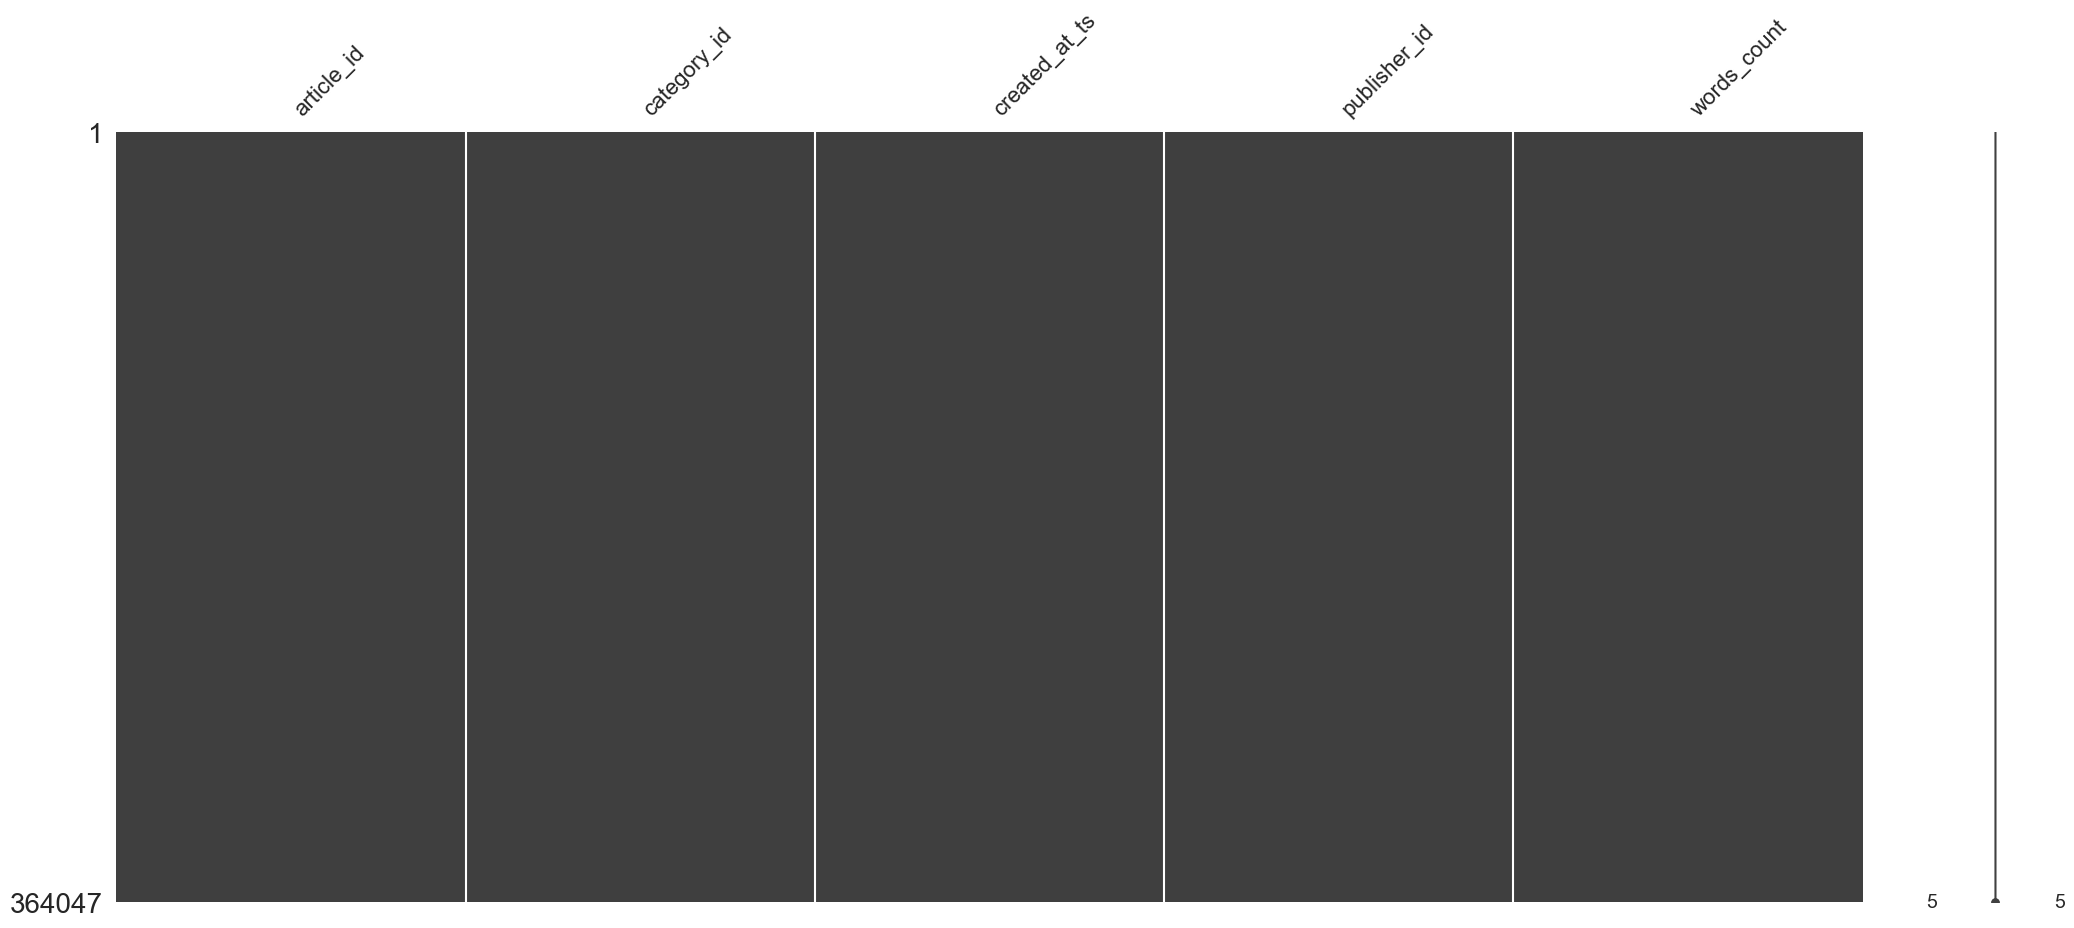

In [6]:
missingno.matrix(articles_df);

Pas de valeur manquante

### Word_count

In [7]:
articles_df['words_count'].describe()

count    364047.000000
mean        190.897727
std          59.502766
min           0.000000
25%         159.000000
50%         186.000000
75%         218.000000
max        6690.000000
Name: words_count, dtype: float64

In [9]:
print(f"Nombre d'articles à 0 mots : {len(articles_df[articles_df['words_count'] == 0])}")

Nombre d'articles à 0 mots : 35


In [21]:
print(f"Nombre d'articles au-dessus de 500 mots : {len(articles_df[articles_df['words_count'] > 500])}")

Nombre d'articles au-dessus de 500 mots : 541


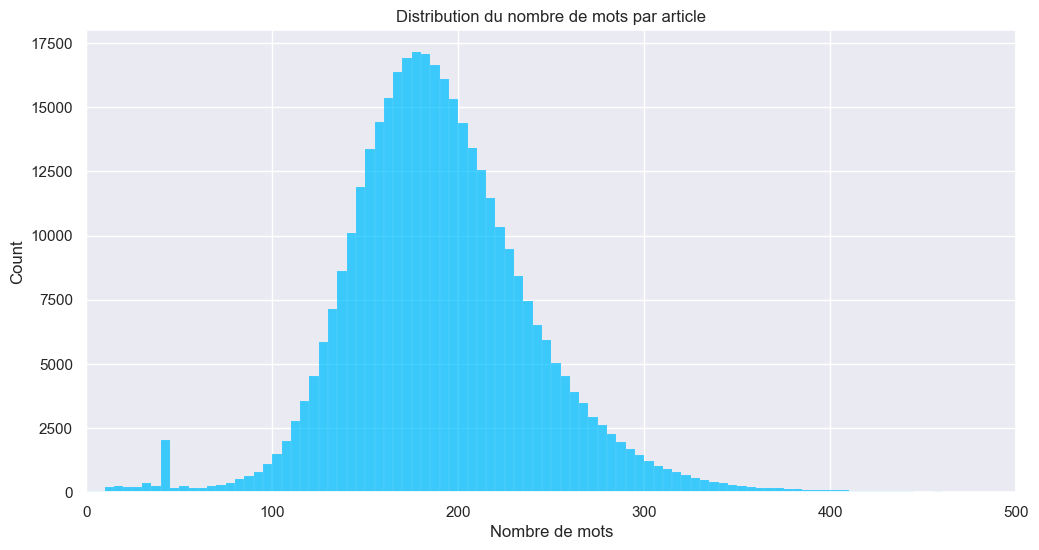

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(articles_df['words_count'], color="deepskyblue", binwidth=5, ax=ax)
plt.xlim([0, 500])
plt.xlabel('Nombre de mots')
plt.title('Distribution du nombre de mots par article');
plt.show()

### Article_id

Combien d'articles ?

In [64]:
len(articles_df['article_id'].unique())

364047

### Category_id

Combien de catégories ?

In [65]:
len(articles_df['category_id'].unique())

461

Catégories ayant le plus d'articles

In [33]:
articles_df.groupby('category_id').count().sort_values(by='article_id', ascending=False).head(10).iloc[:, :1]

,article_id
category_id,
281,12817
375,10005
399,9049
412,8648
431,7759
428,7731
26,7343
7,6726
299,6634


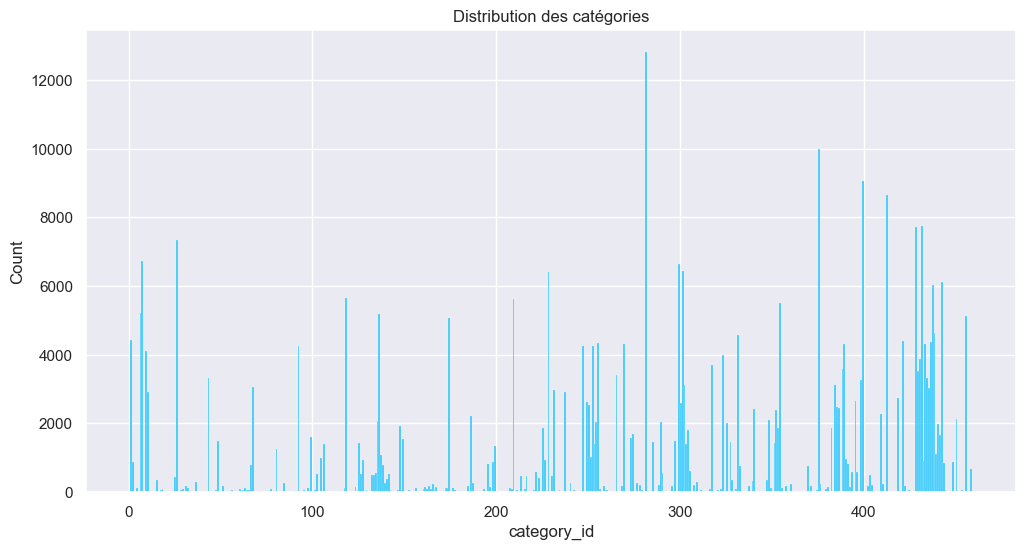

In [34]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(articles_df['category_id'], color="deepskyblue", binwidth=1, ax=ax)
plt.title('Distribution des catégories');
plt.show()

### Created_at_ts

Nombre d'articles créés par année

In [45]:
articles_df['created_at_dt'] = pd.to_datetime(articles_df['created_at_ts'] / 1000, unit='s')

In [53]:
articles_df.sort_values(by='created_at_dt').groupby(articles_df['created_at_dt'].dt.year).count().iloc[:, :1].reset_index()

,created_at_dt,article_id
0,2006,9
1,2007,33
2,2008,7
3,2009,13
4,2010,61
5,2011,170
6,2012,341
7,2013,18895
8,2014,34243
9,2015,49604


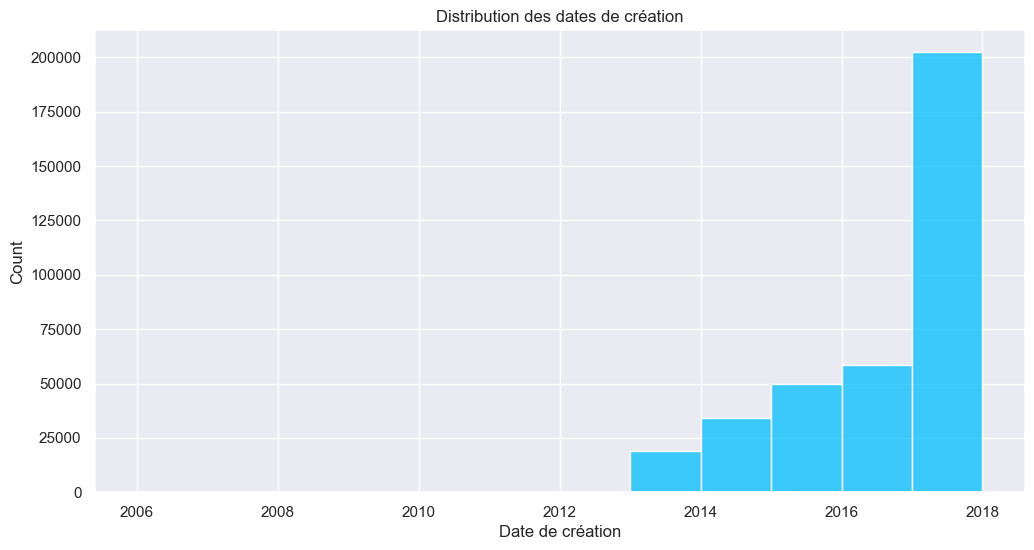

In [55]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(articles_df.sort_values(by='created_at_dt')['created_at_dt'].dt.year, color="deepskyblue",
             binwidth=1, ax=ax)
plt.xlabel('Date de création')
plt.title('Distribution des dates de création');
plt.show()

*[(Retour sommaire)](#Sommaire)*

***

## 2.2 clicks_hour_{}.csv

### Contenu

In [56]:
clicks_samp_df = pd.read_csv('data/clicks_sample.csv')

In [57]:
clicks_samp_df.head(5)

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


Les 12 colonnes de clicks_{}.csv (la signification des colonnes est déduite des données) :
- **user_id** : ID d'utilisateur
- **session_id** : ID de session
- **session_start** : Démarrage de la session (timestamp)
- **session_size** : Nombre de clicks pas session
- **click_article_id** : ID de l'article que l'utilisateur consulte
- **click_timestamp** : Moment du click utilisateur (timestamp)
- **click_environment** : Environnement d'accès (User Agent) de l'utilisateur
- **click_deviceGroup** : Groupe de terminal utilisé
- **click_os** : OS utilisateur
- **click_country** : Localisation (pays) depuis laquelle l'utilisateur a clické
- **click_region** : Localisation (région) depuis laquelle l'utilisateur a clické
- **click_referrer_type** : Origine du click

### Aggrégation de tous les fichiers du dossier "clicks"

In [114]:
def get_clicks():
    
    """
    Renvoi une aggrégation de tous les fichiers clicks_hour_{}.csv du dossier data
    Lit le CSV si une version existe sur disque, sinon la construit et l'écrit dans le dossier data
        @return <pd.DataFrame> : dataframe des clicks utilisateurs
    """
    
    if not os.path.exists('data/clicks.csv'):
        clicks_dir = "data/clicks"
        clicks_path = []
        clicks_path = clicks_path + sorted(
                [os.path.join(clicks_dir, fname) for fname in os.listdir(clicks_dir) if fname.endswith(".csv")]
            )
        print("Number of clicks csv:", len(clicks_path))
        _li = []
        for filename in clicks_path:
            df = pd.read_csv(filename, index_col=None, header=0)
            _li.append(df)
        clicks = pd.concat(_li, axis=0, ignore_index=True)
        clicks.to_csv('data/clicks.csv', index=False)
    else:
        clicks= pd.read_csv('data/clicks.csv')
    return clicks

In [99]:
%%time
clicks_df = get_clicks()

Number of clicks csv: 385
CPU times: total: 46.2 s
Wall time: 46.8 s


In [115]:
clicks_df = pd.read_csv('data/clicks.csv')

### Description

In [61]:
clicks_df.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [62]:
clicks_df.describe(include='all')

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181
unique,322897,1048594,646874,72,46033,2983198,3,5,8,11,28,7
top,5890,1507563657895091,1507563657000,2,160974,1506961009961,4,1,17,1,25,2
freq,1232,124,127,1260372,37213,3,2904478,1823162,1738138,2852406,804985,1602601


### Valeurs manquantes

<AxesSubplot: >

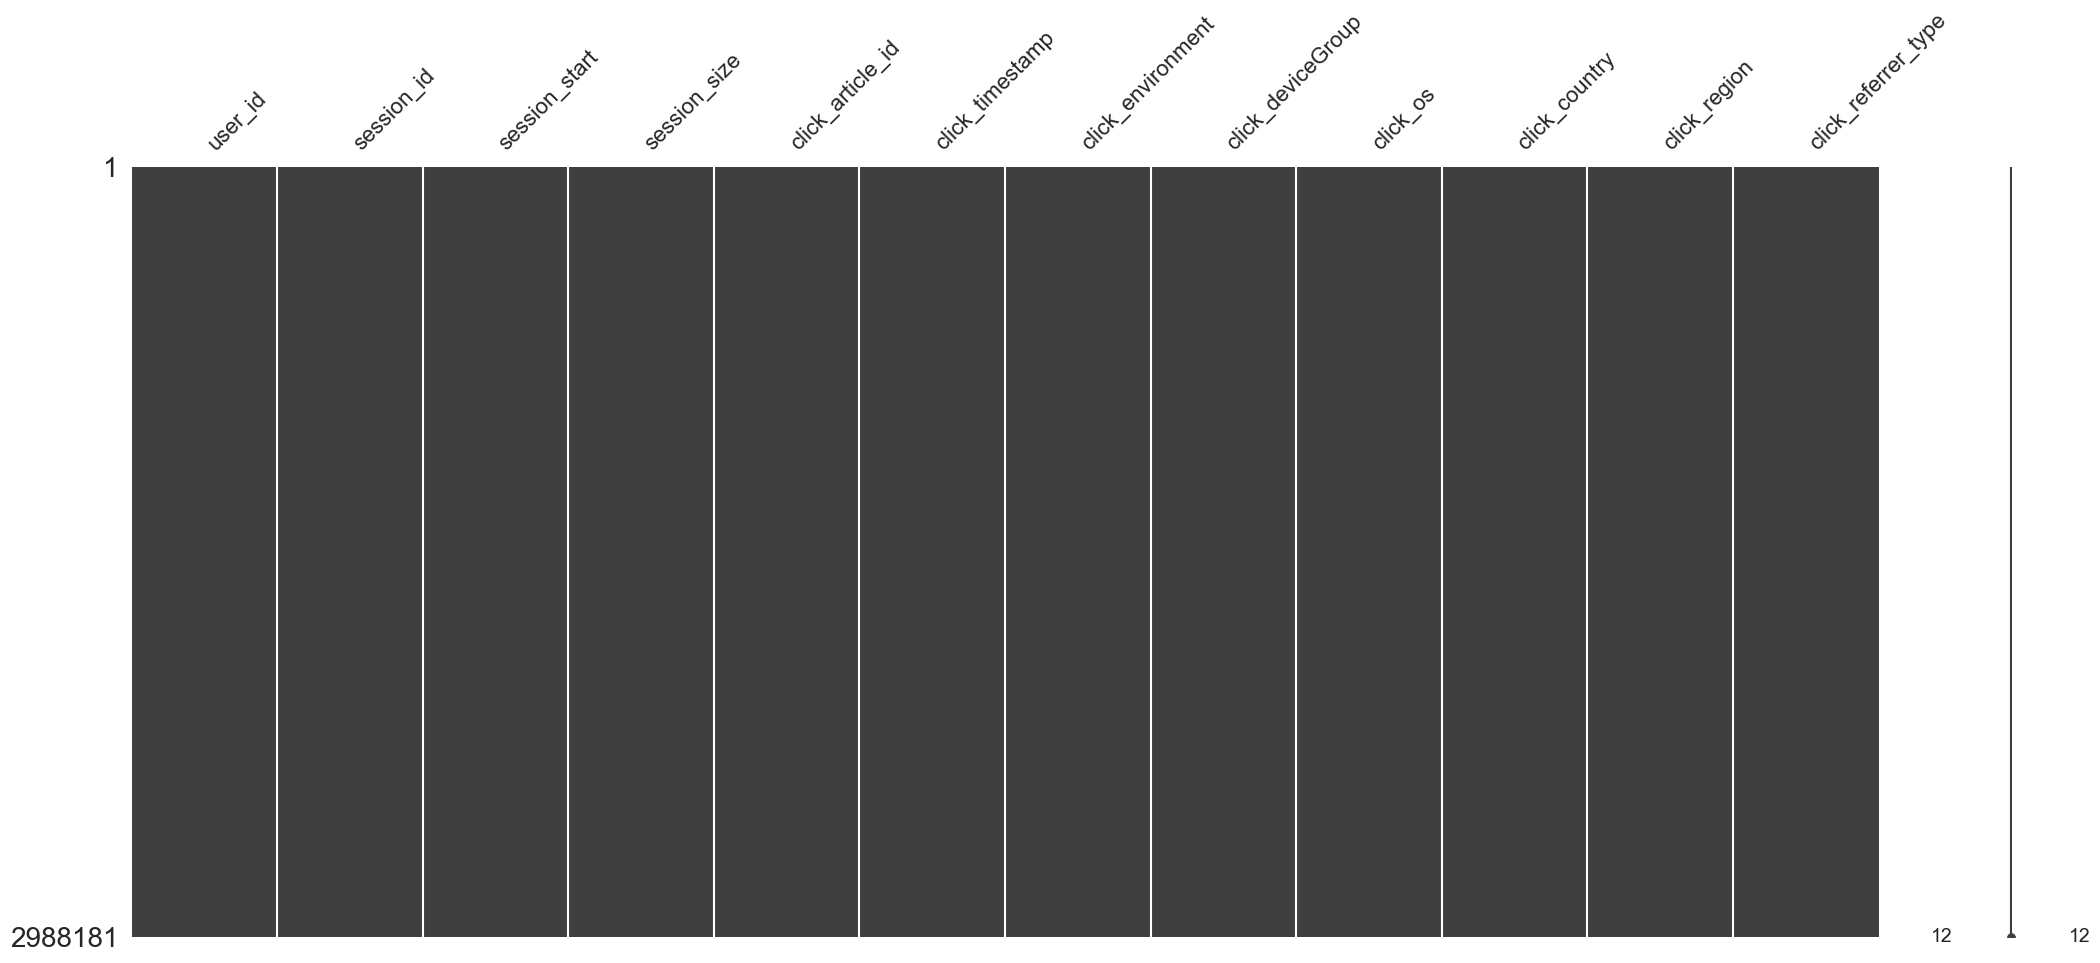

In [66]:
missingno.matrix(clicks_df)

### Distributions

Colonnes liées à la session, la localisation et l'environnement technique

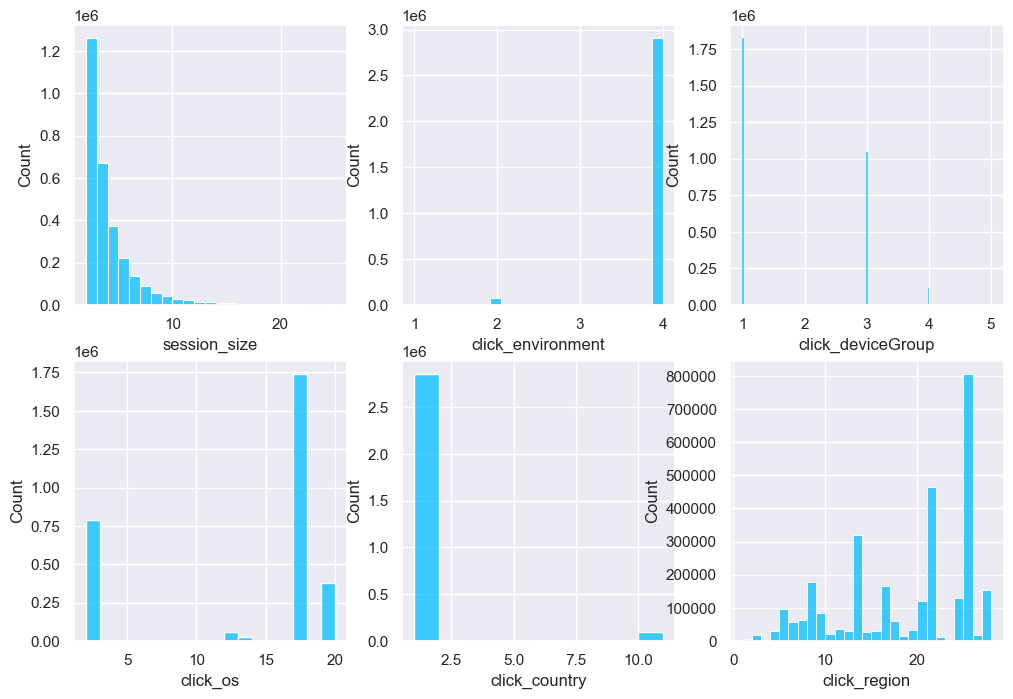

In [91]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
sns.histplot(clicks_df.loc[clicks_df['session_size'] <= 25, 'session_size'], color="deepskyblue", binwidth=1, ax=ax[0, 0])
sns.histplot(clicks_df['click_environment'], color="deepskyblue", ax=ax[0, 1])
sns.histplot(clicks_df['click_deviceGroup'], color="deepskyblue", ax=ax[0, 2])
sns.histplot(clicks_df['click_os'], color="deepskyblue", binwidth=1, ax=ax[1, 0])
sns.histplot(clicks_df['click_country'], color="deepskyblue", binwidth=1, ax=ax[1, 1])
sns.histplot(clicks_df['click_region'], color="deepskyblue", binwidth=1, ax=ax[1, 2])
plt.show()

Dates des clicks

In [74]:
clicks_date = clicks_df[['click_timestamp']]
clicks_date['click_dt'] = pd.to_datetime(clicks_date['click_timestamp'] / 1000, unit='s')

C:\Users\aledo\AppData\Local\Temp\ipykernel_5456\2989924952.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clicks_date['click_dt'] = pd.to_datetime(clicks_date['click_timestamp'] / 1000, unit='s')


In [78]:
clicks_date.sort_values(by='click_dt').groupby([
    clicks_date['click_dt'].dt.year.values,
    clicks_date['click_dt'].dt.month.values
]).count().iloc[:, :1].reset_index()

,level_0,level_1,click_timestamp
0,2017,10,2988167
1,2017,11,14


In [81]:
del clicks_date
gc.collect()

3238552

### Corrélations linéaires

<AxesSubplot: >

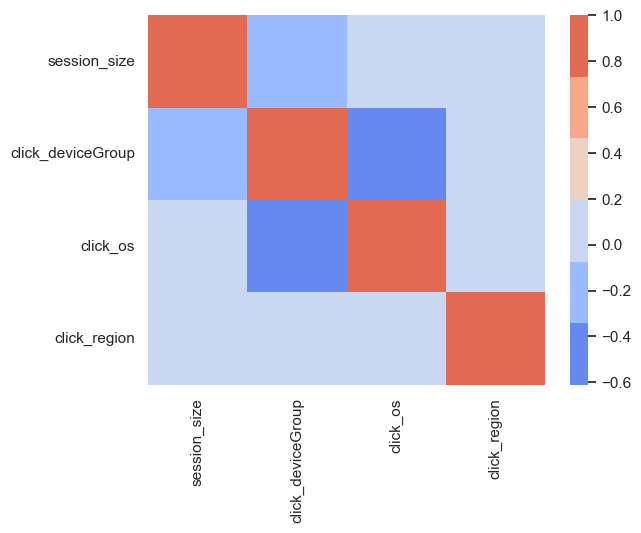

In [88]:
sns.heatmap(clicks_df[['session_size', 'click_deviceGroup', 'click_os', 'click_region']].astype('float64').corr(),
            cmap=sns.color_palette('coolwarm'))

*[(Retour sommaire)](#Sommaire)*

***

# 3. Modèle de recommandation Collaborative filtering

<div class="alert alert-block alert-info">

Le développement ci-dessous d'inspire des notebooks Kaggle suivant :
- https://www.kaggle.com/code/tiramysu/how-to-build-recommendation-engine
- https://www.kaggle.com/code/devmaxime/intro-to-recommendation-systems/notebook
    
    
Et l'article suivant :
- https://realpython.com/build-recommendation-engine-collaborative-filtering/#using-python-to-build-recommenders
    
</div>

## 3.1 Préparation des données

In [7]:
clicks_df.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [8]:
articles_df.head()

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


Nous allons considérer que l'intérêt d'un utilisateur se traduit par :
 - un nombre de clicks sur une catégorie
 - un nombre de clicks sur un article
 
Dans les sous-parties 3.2 à 3.4 ci-dessous, nous examinerons ces deux approches.

### Ratings

Ici nous récupérons le nombre de clicks de chaque utilisateur sur chaque catégorie

In [102]:
def get_cat_rating_by_user(cli_df=None, art_df=None):
    
    """
    Renvoi un dataframe des catégories par user_id avec nombre de consultation
    Lit le CSV si une version existe sur disque, sinon la construit et l'écrit dans le dossier data
        @param cli_df <pd.DataFrame> : aggrégation des fichiers clicks_hour_{}.csv
        @param art_df <pd.DataFrame> : dataframe des articles
        @return <pd.DataFrame> : dataframe des catégories par user_id avec nombre de consultation
    """
    
    df = None
    if not os.path.exists('data/cat_rating_by_user.csv'):
        
        # Récupère les dataframes de base
        if cli_df is get_cat_rating_by_user.__defaults__[0]:
            cli_df = get_clicks()
        if art_df is get_cat_rating_by_user.__defaults__[1]:
            art_df = pd.read_csv('data/articles_metadata.csv')
            
        # Joint les dataframes ensembles
        if 'click_article_id' in cli_df.columns:
            cli_df.rename(columns={'click_article_id':'article_id'}, inplace = True)
        df = cli_df[['user_id', 'article_id']].join(
            art_df[['article_id', 'category_id']].set_index('article_id'), how='left', on='article_id')
        
        # Liste les catégories consultés par chaque user_id avec le nombre de clicks, et sauvegarde
        df = df.groupby(['user_id', 'category_id']).count().reset_index()
        df.rename(columns={'article_id':'nb_clicks'}, inplace = True)
        df.to_csv('data/cat_rating_by_user.csv', index=False)
        
    else:
        df= pd.read_csv('data/cat_rating_by_user.csv')
        
    return df

In [15]:
%%time
cat_rating_by_user = get_cat_rating_by_user(clicks_df, articles_df)

CPU times: total: 7.97 s
Wall time: 8 s


In [16]:
cat_rating_by_user.head()

,user_id,category_id,nb_clicks
0,0,136,1
1,0,186,2
2,0,209,1
3,0,281,2
4,0,375,1


Forme du dataframe obtenu :

In [37]:
cat_rating_by_user.shape

(1882302, 3)

**Rationalisation du nombre de clicks**

In [35]:
print(f"Nombre minimum de clicks : {cat_rating_by_user['nb_clicks'].min()}")
print(f"Nombre maximum de clicks : {cat_rating_by_user['nb_clicks'].max()}")

Nombre minimum de clicks : 1
Nombre maximum de clicks : 535


Vu le grand écart de valeur, nous n'allons garder que les valeurs de rating > 1% du total des clicks

In [53]:
clicks_analyse = cat_rating_by_user.sort_values(by='nb_clicks').groupby('nb_clicks').count().reset_index().iloc[:, :2]

In [54]:
clicks_analyse.head()

,nb_clicks,user_id
0,1,1378686
1,2,293327
2,3,97043
3,4,43989
4,5,23658


In [63]:
threshold = clicks_analyse['user_id'].sum() / 100    # Nous allons garder uniquement les valeurs > 1% 

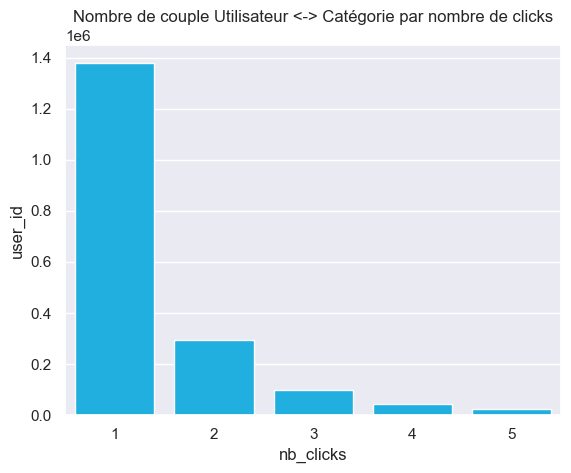

In [64]:
plt.plot(figsize=(15, 6))
sns.barplot(data=clicks_analyse[clicks_analyse['user_id'] > threshold], x='nb_clicks', y='user_id', color="deepskyblue")
plt.title('Nombre de couple Utilisateur <-> Catégorie par nombre de clicks')
plt.show()

<div class="alert alert-block alert-info">

Nous nous intéresserons donc aux nombres de clicks de 1 à 5, car ils capturent 99% des évaluations exprimées. Les évaluations supérieures sont ramenées à une valeur de 5.
    
</div>

In [20]:
cat_rating_by_user['nb_clicks'] = cat_rating_by_user['nb_clicks'].apply(lambda x: x if x <= 5 else 5)

In [21]:
cat_rating_by_user['nb_clicks'].max()

5

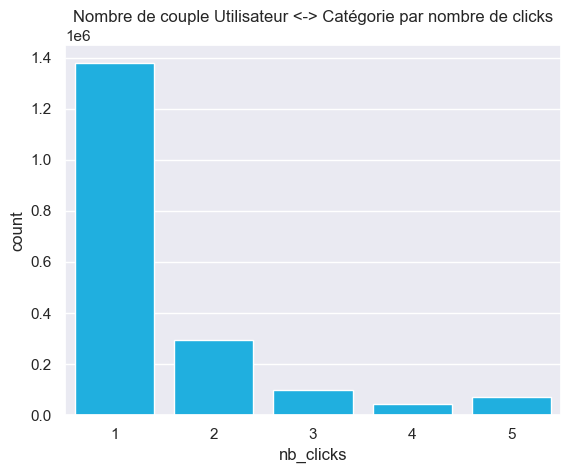

In [30]:
plt.plot(figsize=(15, 6))
sns.countplot(cat_rating_by_user, x='nb_clicks', color="deepskyblue")
plt.title('Nombre de couple Utilisateur <-> Catégorie par nombre de clicks')
plt.show()

**Ajout des articles non lus pour compléter la matrice user-interaction**

Création d'une matrice user-interaction sur la base du nombre de clicks par utilisateur et par catégorie

In [6]:
cat_rating_by_user = get_cat_rating_by_user()

In [7]:
user_int_mat = pd.pivot_table(cat_rating_by_user, index=['user_id'], columns=['category_id'], values='nb_clicks')
user_int_mat.shape

(322897, 316)

In [8]:
user_int_mat.fillna(0, inplace=True)
user_int_mat.head()

category_id,1,2,3,4,6,7,9,11,15,16,17,18,19,20,21,22,24,25,26,27,28,29,31,32,34,36,37,39,40,41,42,43,44,46,47,48,51,54,55,56,58,60,62,63,64,65,66,67,68,69,70,71,72,74,75,76,77,81,84,87,89,90,92,95,96,97,99,101,102,103,104,107,114,115,116,117,118,119,120,122,123,125,126,127,128,130,132,133,134,135,136,137,138,140,141,142,146,147,148,151,152,156,159,160,161,162,163,164,165,166,167,171,172,173,174,175,176,177,180,183,184,186,187,188,191,193,195,196,197,198,201,202,203,204,207,208,209,211,213,215,216,218,219,220,221,222,223,225,226,227,228,229,230,231,233,234,236,237,238,240,242,243,244,245,247,249,250,252,254,255,256,257,258,259,260,262,263,264,265,266,267,268,269,270,271,272,275,276,277,278,279,281,284,285,287,288,289,290,291,295,297,298,299,300,301,302,304,305,307,309,310,311,314,316,317,318,320,322,323,325,326,327,328,329,330,331,332,333,337,339,340,342,348,349,351,352,353,354,355,357,359,360,362,363,367,368,369,370,371,372,373,374,375,376,377,379,380,381,382,384,385,388,389,390,391,392,393,395,396,398,399,401,402,403,404,405,406,407,408,409,410,412,413,414,415,417,418,420,421,422,424,428,429,430,431,433,434,435,436,437,438,442,443,444,445,447,448,449,450,451,453,454,455,456,458,460
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.

In [9]:
user_int_mat.to_csv('data/user_int_mat.csv')

Linéarisation de la matrice pour s'ajuster au format Surprise

In [365]:
uid = user_int_mat.index
repeated_uid = np.tile(uid, user_int_mat.shape[1])
len(repeated_uid)

102035452

In [367]:
user_int = user_int_mat.melt()
user_int.insert(0, 'user_id', repeated_uid)
user_int.head()

,user_id,category_id,value
0,0,1,0.0
1,1,1,0.0
2,2,1,0.0
3,3,1,0.0
4,4,1,0.0


In [368]:
user_int.shape

(102035452, 3)

In [369]:
user_int.to_csv('data/user_int.csv', index=False)

### Liste des articles par utilisateur

La liste des articles par utilisateur nous sert pour la constuction de la matrice user-interaction au niveau de l'article, et pour pouvoir filtrer les recommandations afin de s'assurer de ne pas proposer un article déjà consulté par l'utilisateur.

In [4]:
def get_articles_by_user(cli_df=None):
    
    """
    Renvoi un dataframe des articles consultés par user_id
    Lit le CSV si une version existe sur disque, sinon la construit et l'écrit dans le dossier data
        @param cli_df <pd.DataFrame> : aggrégation des fichiers clicks_hour_{}.csv
        @param art_df <pd.DataFrame> : dataframe des articles
        @return <pd.DataFrame> : dataframe des articles consultés par user_id
    """
    
    df = None
    if not os.path.exists('data/articles_by_user.csv'):
        
        # Récupère le dataframe de base
        if cli_df is get_articles_by_user.__defaults__[0]:
            cli_df = get_clicks()
        
        # Liste les articles consultés par chaque user_id
        if 'click_article_id' in cli_df.columns:
            cli_df.rename(columns={'click_article_id':'article_id'}, inplace = True)
        df = cli_df[['user_id', 'article_id', 'click_timestamp']]
        df.groupby(['user_id', 'article_id']).count().reset_index()
        df = df.drop(columns='click_timestamp')
        df.to_csv('data/articles_by_user.csv', index=False)
        
    else:
        df= pd.read_csv('data/articles_by_user.csv')
        
    return df

In [5]:
%%time
articles_by_user = get_articles_by_user()

CPU times: total: 1.08 s
Wall time: 1.13 s


In [33]:
articles_by_user.sort_values(by='user_id').head()

,user_id,article_id
0,0,157541
1287361,0,96755
1287362,0,313996
1352197,0,160158
1352198,0,233470


Forme du dataframe obtenu :

In [38]:
articles_by_user.shape

(2988181, 2)

*[(Retour sommaire)](#Sommaire)*

***

## 3.2 Collaborative-filtering à l'article avec Surprise

### Fonctions

In [2]:
def get_train_test(art_rating_df, train_size=0.75):
    
    """
    Implémentation manuelle du split train/test, car le train_test_split et GridSearchCV de Surprise
    ne sont pas compatibles (il manque des attributs à l'élément <surprise.Trainset> dont GridSearchCV a besoin).
        @param: cat_rating_df <Pandas.DataFrame> : Dataframe du nombre de clicks par utilisateur et par catégorie
            Doit comporter les colonnes 'user_id', 'category_id' et 'nb_clicks', avec 'nb_clicks' de 1 à 5
        @param train_size <int> : fraction du Dataframe à utiliser pour l'entraînement (par défaut 75%)
        @return <surprise.Dataset>, <surprise.Testset> : train_set, test_set aux proportions indiquées
    """
    
    ratings = art_rating_df[['user_id', 'article_id', 'value']].sort_values(by='user_id')
    
    # Coupure train/test à l'endroit indiqué
    breakpoint = int(len(ratings) * train_size)
    train_candidate = ratings.head(breakpoint)
    test_candidate = ratings.iloc[breakpoint:, :]
    
    # Suppression de l'utilisateur coupé en 2 s'il existe
    common = pd.merge(train_candidate, test_candidate, how='inner', on='user_id')
    common_uid = set(common['user_id'].to_list())
    train_candidate = train_candidate[~train_candidate['user_id'].isin(common_uid)]
    test_candidate = test_candidate[~test_candidate['user_id'].isin(common_uid)]
    print('Longueur du Train set :', len(train_candidate))
    print('Longueur du Test set :', len(test_candidate))
    
    # Transformation en datasets Surprise
    reader = Reader()   # Le rating_scale par défaut est déjà (1, 5)
    train_set = Dataset.load_from_df(train_candidate, reader)
    test_candidate = Dataset.load_from_df(test_candidate, reader)
    dummy, test_set = train_test_split(test_candidate, test_size=1.0)    # Hack
    
    return train_set, test_set

In [27]:
# Source : https://github.com/NicolasHug/Surprise/blob/master/examples/top_n_recommendations.py
def get_top_n_art(predictions, deja_lus, n=5):
    """
    Renvoi les n articles les plus recommandées pour chaque utilisateur parmis ceux non lus
        @param predictions <Surprise Prediction> : prédictions issues de la méthode "test" d'un modèle Surprise
        @param deja_lus <list> : liste des articles déjà lus par l'utilisateur
        @param n <int> : nombre de recommandations à émettre
        @return <dict> : dictionnaire {user_id: [(category_id, predicted_rating), ...]}
    """
    # Map the predictions to each user
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        if iid not in deja_lus:
            top_n[uid].append((iid, est))

    # Sort the predictions for each user and retrieve the k highest ones
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [28]:
def make_recommandation(model, user_id, art_by_user, art_df, n=5):
    """
    Renvoi les articles les plus recommandés pour un utilisateur donné
        @param model <Surprise.SVD> : model entraîné servant à la prédiction
        @param user_id <int> : utilisateur pour qui effectuer la prédiction
        @param art_by_user <Pandas.DataFrame> : dataframe des interactions utilisateur/article
        @param art_df <Pandas.DataFrame> : dataframe listant les articles et leur catégorie
        @param n <int> : nombre d'articles à renvoyer (défaut : 5)
        @return <list>, <list>, <list>, <list> : articles prédits, articles consultés, catégories prédites,
            catégories consultées
    """
    # Constuction du dataset pour l'utilisateur user_id
    user_sel = art_by_user[art_by_user['user_id'] == user_id]
    user_sel['value'] = 1
    user_art_list = user_sel['article_id'].values
    missing_art = [a for a in article_list if not a in user_art_list]
    user_fill = np.full((len(missing_art),), user_id)
    value_fill = np.full((len(missing_art),), 0)
    missing = pd.DataFrame({'user_id': user_fill, 'article_id': missing_art, 'value': value_fill})
    user_sel = pd.concat([user_sel, missing], ignore_index=True)
    
    # Récupération de la prédiction
    pred = model.test(user_sel.to_numpy())
    top_n = get_top_n_art(pred, user_art_list)
    
    # Préparation des données retournées
    pred_list = [art for art, _ in top_n[100000]]
    pred_cat = list(set(art_df[art_df['article_id'].isin(pred_list)]['category_id'].values))
    read_cat = list(set(art_df[art_df['article_id'].isin(user_art_list)]['category_id'].values))
    
    return pred_list, user_art_list, pred_cat, read_cat

### Constitution des datasets

In [2]:
articles_by_user = pd.read_csv('data/articles_by_user.csv')

In [3]:
articles_df = pd.read_csv('data/articles_metadata.csv')

<div class="alert alert-block alert-warning">
    
Nous sommes obligés de réduire à un petit échantillon d'utilisateurs (10 000) afin d'éviter les problèmes de dépassement mémoire
    
</div>

Dataframes utiles à l'entraînement

In [7]:
user_short = articles_by_user[articles_by_user['user_id'] < 10000]
user_short.insert(2, 'rating', np.ones((len(user_short),), dtype=int))
user_list = user_short['user_id'].unique()
article_list = articles_by_user['article_id'].unique()

Forme de la matrice user-interaction

In [5]:
base_mat = np.zeros((len(user_list), len(article_list)), dtype=int)
base_mat = pd.DataFrame(data=base_mat, index=user_list, columns=article_list)
base_mat.shape

(10000, 46033)

Formattage de la matrice user-interaction pour utilisation de SVD avec Surprise

In [6]:
%%time
base_mat = pd.pivot_table(data=user_short, index='user_id', columns='article_id', values='rating', fill_value=0)

CPU times: total: 15.3 s
Wall time: 14.7 s


Nombre de lignes de matrice

In [7]:
uid = base_mat.index
repeated_uid = np.tile(uid, base_mat.shape[1])
len(repeated_uid)

124230000

In [8]:
user_art = base_mat.melt()
user_art.insert(0, 'user_id', repeated_uid)
user_art.head()

,user_id,article_id,value
0,0,94,0
1,1,94,0
2,2,94,0
3,3,94,0
4,4,94,0


In [10]:
user_art.to_csv('data/user_art.csv', index=False)

### SVD (Singular Value Decomposition)

In [13]:
train_set, test_set = get_train_test(user_art)

Longueur du Train set : 93172500
Longueur du Test set : 31057500


In [14]:
test_set[0]

(8397, 286035, 0.0)

**Entraînement**

In [15]:
param_grid = {
    'n_factors': [50, 100, 150],
    'n_epochs': [10, 20, 30],
    'lr_all': [0.001, 0.005, 0.01]
}
svd_grid = GridSearchCV(SVD, param_grid, refit=True, measures=["rmse"], n_jobs=-1, joblib_verbose=2, cv=5)

In [ ]:
%%time
svd_grid.fit(data=train_set)

**Résultats**

In [ ]:
print(f"Meilleurs paramètres : {svd_grid.best_params}")

**Sauvegarde du model**

In [ ]:
with open(os.path.join('models', 'svd_art.pkl'), 'wb') as f:
    pickle.dump(svd_grid, f)

**Test pour utilisateur n°100000**

In [29]:
with open(os.path.join('models', 'svd_art.pkl'), 'rb') as f:
    model = pickle.load(f)

In [41]:
%%time
user_id = 100000
pred_list, user_art_list, pred_cat, read_cat = make_recommandation(model, user_id, articles_by_user, articles_df)
print(f"Articles recommandés pour l'utilisateur {user_id} : {pred_list}")
print(f"Rappel des articles consultés par l'utilisateur : {user_art_list}")
print(f"Catégories des articles recommandés : {pred_cat}")
print(f"Rappel des catégories consultés par l'utilisateur : {read_cat}")

C:\Users\aledo\AppData\Local\Temp\ipykernel_12000\3520909208.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_sel['value'] = 1


Articles recommandés pour l'utilisateur 100000 : [162270, 64524, 62623, 189530, 282057]
Rappel des articles consultés par l'utilisateur : [218337 160417 158536  96210 336245]
Catégories des articles recommandés : [135, 304, 281, 412, 127]
Rappel des catégories consultés par l'utilisateur : [352, 209, 437, 281]
CPU times: total: 2.16 s
Wall time: 2.17 s


*[(Retour sommaire)](#Sommaire)*

***

## 3.3 Collaborative-filtering à la catégorie avec Surprise

### Fonctions

In [2]:
def get_train_test(cat_rating_df, train_size=0.75):
    
    """
    Implémentation manuelle du split train/test, car le train_test_split et GridSearchCV de Surprise
    ne sont pas compatibles (il manque des attributs à l'élément <surprise.Trainset> dont GridSearchCV a besoin).
        @param: cat_rating_df <Pandas.DataFrame> : Dataframe du nombre de clicks par utilisateur et par catégorie
            Doit comporter les colonnes 'user_id', 'category_id' et 'nb_clicks', avec 'nb_clicks' de 1 à 5
        @param train_size <int> : fraction du Dataframe à utiliser pour l'entraînement (par défaut 75%)
        @return <surprise.Dataset>, <surprise.Testset> : train_set, test_set aux proportions indiquées
    """
    
    ratings = cat_rating_df[['user_id', 'category_id', 'value']].sort_values(by='user_id')
    
    # Coupure train/test à l'endroit indiqué
    breakpoint = int(len(ratings) * train_size)
    train_candidate = ratings.head(breakpoint)
    test_candidate = ratings.iloc[breakpoint:, :]
    
    # Suppression de l'utilisateur coupé en 2 s'il existe
    common = pd.merge(train_candidate, test_candidate, how='inner', on='user_id')
    common_uid = set(common['user_id'].to_list())
    train_candidate = train_candidate[~train_candidate['user_id'].isin(common_uid)]
    test_candidate = test_candidate[~test_candidate['user_id'].isin(common_uid)]
    print('Longueur du Train set :', len(train_candidate))
    print('Longueur du Test set :', len(test_candidate))
    
    # Transformation en datasets Surprise
    reader = Reader()   # Le rating_scale par défaut est déjà (1, 5)
    train_set = Dataset.load_from_df(train_candidate, reader)
    test_candidate = Dataset.load_from_df(test_candidate, reader)
    dummy, test_set = train_test_split(test_candidate, test_size=1.0)    # Hack
    
    return train_set, test_set

In [277]:
def get_predict(model, testSet):
    
    """
    Affiche les valeurs d'erreur RMSE, MSE et MAE de la prédiction globale sur un testSet
    Affiche le nombre de clicks réels et prédits pour un utilisateur au hasard issu du test_set
        @param model <Surprise Model> : model à utiliser pour effectuer la prédiction
        @param testSet <Surprise Testset> : test set sur lequel effectuer la prédiction
        @return <Surprise Prediction> : lot de prédictions issues du test set
    """
    
    predict = model.test(testSet)
    #accuracy.rmse(predict)
    #accuracy.mse(predict)
    #accuracy.mae(predict);
    
    return predict

In [17]:
# Source : https://github.com/NicolasHug/Surprise/blob/master/examples/top_n_recommendations.py
def get_top_n_cat(predictions, n=10):
    
    """
    Renvoi les n catégories les plus recommandées pour chaque utilisateur
        @param predictions <Surprise Prediction> : prédictions issues de la méthode "test" d'un modèle Surprise
        @param n <int> : nombre de recommandations à émettre
        @return <dict> : dictionnaire {user_id: [(category_id, predicted_rating), ...]}
    """

    # Map the predictions to each user
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Sort the predictions for each user and retrieve the k highest ones
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [266]:
def get_recommendations(user_id, top_n_cat, cat_by_user, art_by_user, art_df):
    
    """
    Renvoi une liste de 5 articles recommandés pour un utilisateur
        @param user_id <int> : ID de l'utilisateur pour lequel émettre des recommandations
        @param top_n_cat <list(int)> : top N catégories (avec poids associés) recommandées pour l'utilisateur
        @param cat_by_user <Panda.Dataframe> : Dataframe utilisé pour la recommandation si top_n_cat est vide
        @param art_by_user <Panda.Dataframe> : Dataframe des articles déjà lus et à ne pas reproposer
        @param articles_df <Panda.Dataframe> : Dataframe des articles par catégorie pour piocher les suggestions
        @return <list>, <list> : [articles recommandés], [catégories recommandées]
    """
    
    # Recherche des catégories recommandées pour l'utilisateur spécifié
    recommanded_cat = [cat for cat, _ in top_n_cat[user_id]]
    recommanded_wei = [wei for _, wei in top_n_cat[user_id]]
    
    # S'il n'y a pas de recommandation, nous utilisons les catégories historiques de l'utilisateur
    if not recommanded_cat:
        nb_cat = len(cat_by_user[cat_by_user['user_id'] == user_id])
        sorted_cats = cat_by_user[cat_by_user['user_id'] == user_id].nlargest(nb_cat, ['nb_clicks'])
        recommanded_cat = sorted_cats['category_id'].values
        recommanded_wei = sorted_cats['nb_clicks'].values
    
    # Soustraction des articles déjà lus par l'utilisateur
    deja_lu = art_by_user[art_by_user['user_id'] == user_id]['article_id'].values
    possible_art = art_df[~art_df['article_id'].isin(deja_lu)]
    
    # Selection des catégories à représenter en tenant compte des pondérations
    relative_wei = np.rint(np.divide(recommanded_wei, recommanded_wei[-1]))
    selected_cat = []
    for i in range(min(5, len(recommanded_cat))):
        selected_cat = np.concatenate((selected_cat, np.repeat(recommanded_cat[i], recommanded_wei[i])), axis=None)
    selected_cat = selected_cat.astype(int)[:min(5, len(selected_cat))]
    while len(selected_cat) < 5:
        selected_cat = np.concatenate(
            (selected_cat, selected_cat[0: min(len(selected_cat), 5 - len(selected_cat))]), axis=None)
    
    # Sélection des 5 articles non lus les plus populaires parmis les catégories recommandées avec pondération
    selected_art = []
    for c in selected_cat:
        pop_art = art_by_user[['user_id', 'article_id']].join(
            possible_art[['article_id', 'category_id']].set_index('article_id'), how='left', on='article_id')
        pop_art = pop_art.loc[
            (pop_art['category_id'] == c) & (~pop_art['article_id'].isin(selected_art)), ['article_id', 'user_id']]
        pop_art = pop_art.groupby('article_id').count().reset_index().sort_values(by='user_id', ascending=False)
        selected_art.append(int(pop_art.head(1)['article_id'].values))
    
    return list(set(selected_cat)), selected_art

### SVD (Singular Value Decomposition)

In [3]:
user_int = pd.read_csv('data/user_int.csv')

In [4]:
train_set, test_set = get_train_test(user_int[user_int['user_id'] < 150000])

Longueur du Train set : 35550000
Longueur du Test set : 11850000


<div class="alert alert-block alert-warning">
    
Nous sommes là aussi forcés de réduire le nombre d'utilisateurs considérés à cause de considération rerlatives à la mémoire disponible, mais dû au faible nombre de colonnes ici (316), nous pouvons tout de même accroître le nombre de clients dans notre dataset, à savoir 15 fois plus que pour l'étude à l'article, soit un peu moins de la moitié du total de nos utilisateurs.
    
</div>

In [5]:
test_set[0]

(121444, 436, 0.0)

**Entraînement**

In [53]:
param_grid = {
    'n_factors': [50, 100, 150],
    'n_epochs': [10, 20, 30],
    'lr_all': [0.001, 0.005, 0.01]
}
svd_grid = GridSearchCV(SVD, param_grid, refit=True, measures=["rmse"], n_jobs=-1, joblib_verbose=2, cv=5)

In [7]:
%%time
svd_grid.fit(data=train_set)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
C:\Users\aledo\anaconda3\envs\p9\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 45.5min remaining: 68.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 72.2min finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 72.2min remaining:    0.0s


CPU times: total: 1h 23min 53s
Wall time: 2h 36min 56s


**Résultats**

In [8]:
print(f"Meilleurs paramètres : {svd_grid.best_params}")

Meilleurs paramètres : {'rmse': {'n_factors': 100, 'n_epochs': 20, 'lr_all': 0.005}}


**Sauvegarde du model**

In [9]:
with open(os.path.join('models', 'svd_cat.pkl'), 'wb') as f:
    pickle.dump(svd_grid, f)

**Test pour utilisateur = 121444**

In [10]:
with open(os.path.join('models', 'svd_cat.pkl'), 'rb') as f:
    model = pickle.load(f)

In [11]:
user_id = 121444
user_spec = user_int[user_int['user_id'] == user_id]

In [14]:
user_pred = model.test(user_spec.to_numpy())

In [20]:
user_pred

[Prediction(uid=121444.0, iid=1.0, r_ui=0.0, est=1, details={'was_impossible': False}),
 Prediction(uid=121444.0, iid=2.0, r_ui=0.0, est=1, details={'was_impossible': False}),
 Prediction(uid=121444.0, iid=3.0, r_ui=0.0, est=1, details={'was_impossible': False}),
 Prediction(uid=121444.0, iid=4.0, r_ui=0.0, est=1, details={'was_impossible': False}),
 Prediction(uid=121444.0, iid=6.0, r_ui=0.0, est=1, details={'was_impossible': False}),
 Prediction(uid=121444.0, iid=7.0, r_ui=0.0, est=1, details={'was_impossible': False}),
 Prediction(uid=121444.0, iid=9.0, r_ui=0.0, est=1, details={'was_impossible': False}),
 Prediction(uid=121444.0, iid=11.0, r_ui=0.0, est=1, details={'was_impossible': False}),
 Prediction(uid=121444.0, iid=15.0, r_ui=0.0, est=1, details={'was_impossible': False}),
 Prediction(uid=121444.0, iid=16.0, r_ui=0.0, est=1, details={'was_impossible': False}),
 Prediction(uid=121444.0, iid=17.0, r_ui=0.0, est=1, details={'was_impossible': False}),
 Prediction(uid=121444.0, ii

In [21]:
get_top_n_cat(user_pred, 5)

defaultdict(list,
            {121444.0: [(281.0, 1.1574285546623286),
              (1.0, 1),
              (2.0, 1),
              (3.0, 1),
              (4.0, 1)]})

In [23]:
print(f"Articles consultés par l'utilisateur : {articles_by_user[articles_by_user['user_id'] == 121444]['article_id'].values}")

Articles consultés par l'utilisateur : [324823 175040]


In [25]:
print(f"Catégories des articles consultés : {articles_df[articles_df['article_id'].isin([324823, 175040])]['category_id'].values}")

Catégories des articles consultés : [299 434]


<div class="alert alert-block alert-danger">
    
On constate ici que la recommandation à la catégorie via SVD n'a pas fonctionné, puisque'elle se contente de prédire 1 à chaque catégorie, à part sur la catégorie la plus représentée (281, voir l'analyse exploratoire ci-dessus).
    
Nous allons donc tenter une approche manuelle par similarité consinus ci-dessous.
    
</div>

*[(Retour sommaire)](#Sommaire)*

***

## 3.4 Collaborative-filtering à la catégorie : approche manuelle

### Fonctions

In [79]:
def get_recommended_cats(user_interactions, user_id):
    
    """
    Renvoi un vecteur de similarité entre l'utilisateur indiqué et tous les autres
        @param user_interactions <Pandas.Dataframe>: Dataframe des interactions(val) utilisateur(idx)-catégories(col)
        @param user_id <int> : ID de l'utilisateur à comparer
        @return <Pandas.Dataframe> : vecteur 1D des similitudes entre tous les profils utilisateurs et user_id
    """
    
    # Extraction du vecteur utilisateur du user_id
    users = user_interactions['user_id'].values
    user_vector = np.squeeze(np.asarray(user_interactions[user_interactions['user_id'] == user_id].iloc[:, 1:]))
    
    # Création du vecteur de similarités utilisateurs avec user_id
    similarities = []
    for u in tqdm.tqdm(users):
        u_vector = np.squeeze(np.asarray(user_interactions[user_interactions['user_id'] == u].iloc[:, 1:]))
        similarities.append(np.dot(user_vector, u_vector) / (np.linalg.norm(user_vector) * np.linalg.norm(u_vector)))
        
    # Moyenne des notes d'interaction avec chaque catégorie, pondérée des notes de similitude
    cat_vector = np.average(user_interactions.iloc[:, 1:], axis=0, weights=similarities)
    reco = pd.DataFrame({'reco_weight': cat_vector}, index=user_interactions.iloc[:, 1:].columns)
    
    return reco.sort_values(by='reco_weight', ascending=False)

In [99]:
def get_recommended_arts(user_id, top_cats, art_by_user, art_df, n=5):
    
    """
    Renvoi une liste de 5 articles recommandés pour un utilisateur
        @param user_id <int> : ID de l'utilisateur pour lequel émettre des recommandations
        @param top_n_cat <Pandas.Dataframe> : catégories (avec poids associés) triées par recommandation pour user_id
        @param art_by_user <Panda.Dataframe> : Dataframe des articles déjà lus et à ne pas reproposer
        @param articles_df <Panda.Dataframe> : Dataframe des articles par catégorie pour piocher les suggestions
        @return <list>, <list> : [articles recommandés], [catégories recommandées]
    """
    
    # Soustraction des articles déjà lus par l'utilisateur
    deja_lu = art_by_user[art_by_user['user_id'] == user_id]['article_id'].values
    possible_art = art_df[~art_df['article_id'].isin(deja_lu)]
    
    # Filtrage des catégories > 0 de recommandation
    possible_df = top_cats[top_cats['reco_weight'] > 0].head(n)
    possible_cats = np.asarray(possible_df.index.values, dtype=int)
    possible_wei = possible_df['reco_weight'].values
    
    # S'il n'y a pas de recommandation, nous utilisons la "sagesse de la foule"
    if int(np.ceil(max(top_cats['reco_weight']))) == 0:
        selected_art = art_by_user[~art_by_user['article_id'].isin(deja_lu)] \
            .groupby('article_id').count().reset_index().sort_values(by='user_id', ascending=False).head(5)
    
    else:
        # Bourrage par répétitions si la liste des catégories est trop courte
        while len(possible_cats) < n:
            possible_cats = np.concatenate(
                (possible_cats, possible_cats[0: min(len(possible_cats), n - len(possible_cats))]), axis=None)
            possible_wei = np.concatenate(
                (possible_wei, possible_wei[0: min(len(possible_wei), n - len(possible_wei))]), axis=None)

        # Selection des catégories à représenter en tenant compte des pondérations relatives
        relative_wei = np.rint(np.divide(possible_wei, possible_wei[-1]))
        selected_cat = []
        for i in range(min(n, len(possible_cats))):
            selected_cat = np.concatenate((selected_cat, np.repeat(possible_cats[i], possible_wei[i])), axis=None)
        selected_cat = selected_cat.astype(int)[:min(n, len(selected_cat))]
        while len(selected_cat) < n:
            selected_cat = np.concatenate(
                (selected_cat, selected_cat[0: min(len(selected_cat), n - len(selected_cat))]), axis=None)

        # Sélection des N articles non lus les plus populaires parmis les catégories recommandées avec pondération
        selected_art = []
        for c in selected_cat:
            pop_art = art_by_user[['user_id', 'article_id']].join(
                possible_art[['article_id', 'category_id']].set_index('article_id'), how='left', on='article_id')
            pop_art = pop_art.loc[
                (pop_art['category_id'] == c) & (~pop_art['article_id'].isin(selected_art)), ['article_id', 'user_id']]
            pop_art = pop_art.groupby('article_id').count().reset_index().sort_values(by='user_id', ascending=False)
            selected_art.append(int(pop_art.head(1)['article_id'].values))
    
    return selected_art

In [200]:
def compute_metrics(predictions, targets):
    return {
        'rmse': np.sqrt(np.mean((predictions - targets)**2)),
        'mse': np.mean((predictions - targets)**2),
        'mae': np.mean(np.abs(predictions - targets))
    }

### Etude pour l'utilisateur n°2

**Récupération de la matrice user-interaction au niveau de la catégorie**

In [13]:
user_int_mat = pd.read_csv('data/user_int_mat.csv')

**Récupération des catégories recommandées (coeur de l'algorithme)**

In [80]:
reco_cats = get_recommended_cats(user_int_mat, 2)

100%|█████████████████████████████████████████████████████████████████████████| 322897/322897 [09:09<00:00, 587.25it/s]


**Catégories recommandées**

In [81]:
reco_cats.head()

,reco_weight
375,1.131683
281,1.128002
26,1.098699
437,0.802193
412,0.790176


**Catégories réellement consultées**

In [172]:
cat_rating_by_user[cat_rating_by_user['user_id'] == 2]['category_id'].values

array([ 26, 247, 332], dtype=int64)

**Récupération des articles recommandés (sur la base des catégories recommandées)**

In [83]:
art_by_user = get_articles_by_user()
art_df = pd.read_csv('data/articles_metadata.csv')

In [100]:
%%time
reco_arts = get_recommended_arts(2, reco_cats, art_by_user, art_df)

CPU times: total: 3.2 s
Wall time: 3.4 s


**Articles recommandés**

In [101]:
reco_arts

[234698, 160974, 31836, 235616, 162655]

**Catégories des articles recommandés**

In [105]:
set(art_df[art_df['article_id'].isin(reco_arts)]['category_id'].values)

{26, 281, 375}

**Métriques**

In [197]:
reco = reco_cats.copy()
reco.index.names = ['cat_id']
reco = reco.reset_index()
reco['cat_id'] = reco['cat_id'].astype(int)
reco = reco.sort_values(by='cat_id')
reco_vect = np.reshape(reco['reco_weight'].values, (-1, 1))
np.shape(reco_vect)

(316, 1)

In [198]:
pref_vect = np.transpose(user_int_mat[user_int_mat['user_id'] == 2].iloc[:, 1:].values)
np.shape(pref_vect)

(316, 1)

In [201]:
metrics = compute_metrics(reco_vect, pref_vect)
metrics

{'rmse': 0.15536721893248673,
 'mse': 0.02413897271881526,
 'mae': 0.04792655480116084}

*[(Retour sommaire)](#Sommaire)*

***

# 4. Modèle de recommandation Content-based

## 4.1 Embeddings entiers

### Récupération des embeddings des articles

In [26]:
embeddings = pd.read_pickle('data/articles_embeddings.pickle')
embeddings.shape

(364047, 250)

In [108]:
embeddings[:5, :]

array([[-0.16118301, -0.95723313, -0.13794445, ..., -0.231686  ,
         0.5974159 ,  0.40962312],
       [-0.52321565, -0.974058  ,  0.73860806, ...,  0.18282819,
         0.39708954, -0.83436364],
       [-0.61961854, -0.9729604 , -0.20736018, ..., -0.44758022,
         0.8059317 , -0.28528407],
       [-0.7408434 , -0.97574896,  0.39169782, ..., -0.5378381 ,
         0.24354108, -0.8853287 ],
       [-0.2790515 , -0.97231525,  0.68537366, ..., -0.42406067,
         0.18548405, -0.5802922 ]], dtype=float32)

<div class="alert alert-block alert-info">
    
Nous avons un ensemble de 364 047 vecteurs (1 par article) de 250 caractéristiques chacun : l'index de chaque vecteur correspond à l'article_id.
    
</div>

### Fonctions

In [30]:
def get_top_articles(articles, n=1):
    indexed = enumerate(articles)
    sorted_articles = sorted(indexed, key=operator.itemgetter(1), reverse=True) 
    return [a[0] for a in sorted_articles[:n]]

In [31]:
def get_content_recommandations(user_id, embeddings, clicks, n=5):
    
    """
    Produit 5 recommandations d'articles en se basant sur les articles déjà lus par l'utilisateur
        @param user_id <int> : utilisateur pour lequel émettre des recommandations
        @param embeddings <numpy.Array> : ensemble de vecteurs de word embedding de longueur 250
        @param art_by_user <Pandas.Dataframe> : Dataframe des articles lus pour chaque utilisateur
        @return <list> : une liste de 5 articles les plus recommandés pour le profil
    """
    
    # Récupère une liste ordonnée des articles lus : les plus lus et consultés plus récemment sont mieux classés
    art_list = clicks.loc[clicks_df['user_id'] == user_id, ['click_article_id', 'session_size']] \
        .groupby('click_article_id').count().reset_index().set_index('click_article_id') \
        .join(clicks[['click_article_id', 'click_timestamp']], how='left', on='click_article_id') \
        .sort_values(by=['session_size', 'click_timestamp'], ascending=False)
    deja_lu = art_list['click_article_id'].values
    while len(deja_lu) < n:
        deja_lu = np.concatenate((deja_lu, deja_lu[0: min(len(deja_lu), n-len(deja_lu))]), axis=None)
    
    # Calcul la meilleure similarité pour le top N des articles déjà lus
    deja_lu = deja_lu[:n]
    reco = []
    embed_len = len(embeddings)
    for d in deja_lu:
        sim_score = []
        for i in range(embed_len):
            if (i in deja_lu) | (i in reco):
                cos_sim = 0
            else:
                cos_sim = np.dot(embeddings[d], embeddings[i]) / \
                    (np.linalg.norm(embeddings[d]) * np.linalg.norm(embeddings[i]))
            sim_score.append(cos_sim)
        reco.append(get_top_articles(sim_score))
    
    return reco

In [33]:
clicks_df = pd.read_csv('data/clicks.csv')

### Essai de recommandation pour l'utilisateur n°100000

**Articles recommandés**

In [34]:
%%time
get_content_recommandations(100000, embeddings, clicks_df)

CPU times: total: 28.7 s
Wall time: 28.8 s


[[279547], [206570], [156560], [157541], [206845]]

Rappel des recommandations Collaborative-Filtering : [162270, 64524, 62623, 189530, 282057]

Rappel des articles consultés par l'utilisateur : [218337 160417 158536  96210 336245]

**Catégories recommandées**

In [123]:
set(art_df[art_df['article_id'].isin([220928, 161035, 334138, 207129, 220928])]['category_id'].values)

{281, 331, 354, 437}

Rappel des catégories des articles recommandés en Collaborative-Filtering : [135, 304, 281, 412, 127]

Rappel des catégories consultés par l'utilisateur : [352, 209, 437, 281]

*[(Retour sommaire)](#Sommaire)*

***

## 4.2 Embeddings réduits (PCA)

### Réduction de dimensions

In [138]:
from sklearn.decomposition import PCA

In [139]:
pca = PCA(svd_solver='full', n_components=.95).fit_transform(embeddings)

In [140]:
np.shape(pca)

(364047, 52)

In [144]:
pd.to_pickle(pca, 'data/pca_embeddings.pickle')

### Essai de recommandation pour l'utilisateur 2

In [35]:
pca = pd.read_pickle('data/pca_embeddings.pickle')

**Articles recommandés**

In [36]:
%%time
get_content_recommandations(100000, pca, clicks_df)

CPU times: total: 31.5 s
Wall time: 31.6 s


[[279547], [206570], [156560], [157541], [207310]]

Rappel des recommandations Content-Based sans ACP : [279547, 206570, 156560, 157541, 206845]

Rappel des recommandations Collaborative-Filtering : [162270, 64524, 62623, 189530, 282057]

Rappel des articles consultés par l'utilisateur : [218337 160417 158536  96210 336245]

**Catégories recommandées**

In [142]:
set(art_df[art_df['article_id'].isin([329561, 161035, 336221, 207129, 329561])]['category_id'].values)

{281, 331, 436, 437}

Rappel des catégories prédites en Content-Based sans ACP : [281, 331, 354, 437]

Rappel des catégories des articles recommandés en Collaborative-Filtering : [135, 304, 281, 412, 127]

Rappel des catégories consultés par l'utilisateur : [352, 209, 437, 281]

<div class="alert alert-block alert-info">
    
Avec réduction de dimension :
<ul>
    <li>Les articles prédits sont proches de ceux avec full embeddings</li>
    <li>Le temps de prédiction est comparable</li>
    <li>La variance est retenu à 95%</li>
    <li>Le nombre de caractéristiques est divisé par 5</li>
    <li>Le poids des embeddings sur disque est divisé par 5</li>
</ul>
    
</div>

<div class="alert alert-block alert-warning">
    
La méthode Content-Based présente 2 inconvénients majeurs dans notre cas :
- Le temps de prédiction (~30s) : trop long pour un application en production dont il s'agit de la fonctionnalité principale
- Le système de recommandation lui-même : comme nous cherchons à promouvoir la lecture, il faut nécessairement introduire de la diversité dans les choix proposés, ce que le Content-Based aura du mal à faire
    
</div>

*[(Retour sommaire)](#Sommaire)*

***

# 5. Script de calcul des recommandations

<div class="alert alert-block alert-info">

Ayant choisi la méthode Collaborative-Filtering à l'article avec SVD Surprise comme modèle pour la mise en production, nous testons ici un pré-calcul des prédictions du modèle qui nous permettra simplement de lire la réponse dans un tableau au lieu de la calculer via le modèle lors des requêtes utilisateur.

Devant les limitations de ressources de calcul qui sont les nôtres, nous ne testerons que sur un segment de 10,000 utilisateurs : du n°20,000 au n°29,999.
    
    
</div>

### Fonctions

In [5]:
# Source : https://github.com/NicolasHug/Surprise/blob/master/examples/top_n_recommendations.py
def get_top_n_art(predictions, deja_lus, n=5):
    """
    Renvoi les n articles les plus recommandées pour chaque utilisateur parmis ceux non lus
        @param predictions <Surprise Prediction> : prédictions issues de la méthode "test" d'un modèle Surprise
        @param deja_lus <list> : liste des articles déjà lus par l'utilisateur
        @param n <int> : nombre de recommandations à émettre
        @return <dict> : dictionnaire {user_id: [(category_id, predicted_rating), ...]}
    """
    # Map the predictions to each user
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        if iid not in deja_lus:
            top_n[uid].append((iid, est))

    # Sort the predictions for each user and retrieve the k highest ones
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [15]:
def make_recommendation(model, art_by_user, art_df, n=5):
    """
    Renvoi un dataframe des articles les plus recommandés pour tous les utilisateur
        @param model <Surprise.SVD> : model entraîné servant à la prédiction
        @param user_id <int> : utilisateur pour qui effectuer la prédiction
        @param art_by_user <Pandas.DataFrame> : dataframe des interactions utilisateur/article
        @param art_df <Pandas.DataFrame> : dataframe listant les articles et leur catégorie
        @param n <int> : nombre d'articles à renvoyer (défaut : 5)
        @return <Pandas.DataFrame> : user_id, reco_art, reco_cat
    """
    # Variables stockant les résultats
    article_list = art_by_user['article_id'].unique()
    nb_art = len(article_list)
    value_fill = np.full((nb_art,), 0)
    uid_list = art_by_user['user_id'].unique()[20000:30000]
    aid_list = []
    cid_list = []
    
    for u in tqdm.tqdm(uid_list):
        
        # Constuction du dataset de prédiction
        user_fill = np.full((nb_art,), u)
        art_rating = pd.DataFrame({
            'user_id': user_fill,
            'article_id': article_list,
            'value': value_fill
        })

        # Identifiation des articles lus
        user_art_list = art_by_user[art_by_user['user_id'] == u]['article_id'].values
        art_rating.loc[art_rating['article_id'].isin(user_art_list), 'value'] = 1

        # Récupération de la prédiction
        pred = model.test(art_rating.to_numpy())
        top_n = get_top_n_art(pred, user_art_list)

        # Préparation des données retournées
        pred_arts = [art for art, _ in top_n[u]]
        pred_cats = list(set(art_df[art_df['article_id'].isin(pred_arts)]['category_id'].values))

        cid_list.append(", ".join([str(c) for c in list(set(pred_cats))]))
        aid_list.append(",".join([str(a) for a in pred_arts]))
        
    return pd.DataFrame({'user_id': uid_list, 'reco_art': aid_list, 'reco_cat': cid_list})

### Récupération des données et du modèle

In [2]:
articles_by_user = pd.read_csv('data/articles_by_user.csv')

In [3]:
articles_df = pd.read_csv('data/articles_metadata.csv')

In [4]:
with open(os.path.join('models', 'svd_art.pkl'), 'rb') as f:
    model = pickle.load(f)

### Calcul

In [16]:
reco_df = make_recommendation(model, articles_by_user, articles_df)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [2:01:33<00:00,  1.37it/s]


<div class="alert alert-block alert-warning">

2h pour (seulement) 10,000 utilisateurs (non parallélisation des calculs)
    
</div>

In [17]:
reco_df.head()

,user_id,reco_art,reco_cat
0,20000,"332909,220781,194409,339018,30708","354, 437, 438, 26, 317"
1,20001,"41432,106955,298032,97123,161086","67, 228, 428, 211, 281"
2,20002,"59292,251285,205554,201245,72609","388, 325, 137, 331, 118"
3,20003,"76002,86948,118998,285470,97039","209, 147, 247, 186, 412"
4,20004,"51482,273327,151171,276669,309952","281, 104, 399, 431, 409"


In [22]:
reco_df.to_csv('data/reco_df.csv', index=False, sep=";")

In [19]:
ligne = reco_df[reco_df['user_id'] == 20000]

In [21]:
ligne['reco_art'].values[0]

'332909,220781,194409,339018,30708'

*[(Retour sommaire)](#Sommaire)*